In [34]:
import os
import sys
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import pandas as pd
import time

from numpy import sin,cos,arcsin,arccos,dot,pi,sqrt,exp
from scipy.signal import find_peaks
from scipy.special import erf,iv
from tqdm import tqdm
from spacepy import pycdf
from scipy.interpolate import splrep,splev
from scipy.integrate import simpson
from tletools import tle,TLE
from matplotlib import dates as mdates
from scipy.ndimage import uniform_filter1d
%matplotlib widget
plt.style.use('default')

In [35]:
days = mdates.DateLocator()   # date
daysFmt = mdates.DateFormatter('%d')
hoursFmt = mdates.DateFormatter('%H:%M')

In [36]:
R_const = 8.31
k_B = 1.38 * (10**-23)
m_O=16; m_O2=32; m_N=14; m_N2=28; m_H=1; m_He=4;

R_O = (R_const/m_O)*1000;
R_N = (R_const/m_N)*1000;
R_O2 = (R_const/m_O2)*1000;
R_N2 = (R_const/m_N2)*1000;
R_He = (R_const/m_He)*1000;
R_H = (R_const/m_H)*1000;

omega = [0,0,2*np.pi/86400]

m_p = 1.6726 * 10**-27
R_earth = 6.371*10**6
n0 = 1.0e14

# GRACE

In [37]:
sat = 'GRACEA'
sat_in_filename = 'graceA'
m_grace = 432

In [38]:
def sigma_n(m_atm,m_s):
    ## m_atm = molecular mass of incident particle
    ## m_s = molecular mass of surface element
    mu = m_atm/m_s
    alpha = 3.0*mu/((1+mu)**2)
    alpha_n = 2*alpha - 1
    if alpha_n < 0:
        alpha_n = 0
    return 1 - sqrt(1-alpha_n)

def alpha(m_atm,m_s):
    ## m_atm = molecular mass of incident particle
    ## m_s = molecular mass of surface element
    mu = m_atm/m_s
    alpha = 3.0*mu/((1+mu)**2)
    return alpha

def theta(key,temp,nO):
    k_B = 1.38e-23
    P_O = nO*k_B*temp ## partial pressure of O
    if key == "DRIA":
        K = 1.44e6;        
    elif key == "CLL":
        K = 2.89e6;
    th = K*P_O/(1 + K*P_O)
    return th

def gamma1(x):
    return (1/(2*sqrt(pi)))*(exp(-x**2) + sqrt(pi)*x*(1+erf(x)))

def gamma2(x):
    return (1/(2*sqrt(pi)))*(x*exp(-x**2) + (sqrt(pi)/2)*(1 + 2*(x**2))*(1+erf(x)))

def C1(x):
    return (2*x**2 + 3)*iv(0,0.5*x**2) + (2*x**2 + 1)*iv(1,0.5*x**2)
def C2(x):
    return (x**2 + 1)*iv(0,0.5*x**2) + (x**2)*iv(1,0.5*x**2)

def drag_CLL_plane(v,R,temp,angle,sigma_t,sigma_n,T_s):
    ## angle = angle between surface normal and velocity vector
    s = v/sqrt(2*R*temp)
    v_w = sqrt(pi*R*T_s/2)
    g = cos(angle)
    mu = g*s 
    c1 = sigma_t*(1 - g**2)*gamma1(mu)
    c2 = (2-sigma_n)*g*gamma2(mu)/s
    c3 = sigma_n*(v_w/v)*gamma1(mu)*g
    return (2/s)*(c1+c2+c3)

def drag_CLL_sphere(v,R,temp,sigma_t,sigma_n,T_s):
    v_a = sqrt(2*R*temp);
    v_w = sqrt(pi*R*T_s/2);
    s = v/v_a
    p0 = (2 - sigma_n + sigma_t)/(2*(s**3))
    p1= (((4*(s**4)) + (4*(s**2)) - 1)*erf(s)/(2*s)) + ((2*s**2 + 1)*exp(-s**2)/sqrt(pi))
    p2 = (4/3)*sigma_n*(v_w/v) 
    return (p0*p1) + p2

def drag_CLL_cyl(v,R,temp,angle,sigma_t,sigma_n,T_s):
    ## angle = angle between cylindrical axis and velocity vector
    v_a = sqrt(2*R*temp);
    v_w = sqrt(pi*R*T_s/2);
    s = v/v_a
    g = sin(angle)
    mu = g*s
    p0 = (pi/2)*sigma_n*(v_w/v)*(g**2)
    p1 = (sqrt(pi)/(6*s))*(2*sigma_n - sigma_t - 4)*(g**2)*exp(-mu**2/2)*C1(mu)
    p2 = (sqrt(pi)*sigma_t/s)*(1 - g**2)*exp(-mu**2/2)*C2(mu)
    return p0 - p1 + p2

def drag_DRIA_plane(v,R,temp,angle,alpha,T_s):
    s = v/sqrt(2*R*temp)
    g=cos(angle)
    mu = g*s
    P = exp(-mu**2)/s
    Q = 1 + 1/(2*(s**2))
    Z = 1 + erf(g*s)
    ratio = sqrt((2/3)*(1 + alpha*((3*R*T_s/(v**2))-1)))
    C_D = (P/sqrt(pi)) + (g*Q*Z) + ((g/2)*ratio*((g*sqrt(pi)*Z) + P))
    return C_D

def drag_DRIA_sphere(v,R,temp,alpha,T_s):
    s = v/sqrt(2*R*temp)
    ratio = sqrt((2/3)*(1 + alpha*((3*R*T_s/(v**2))-1)))
    p0 = (2*s**2 + 1)*exp(-s**2)/(sqrt(pi) * s**3)
    p1 = (4*s**4 + 4*s**2 - 1)*erf(s)/(2 * s**4)
    p2 = (2*sqrt(pi)/3)*ratio
    return p0 + p1 + p2

def drag_DRIA_cyl(v,R,temp,angle,alpha,T_s):
    s = v/sqrt(2*R*temp)
    g=sin(angle)
    mu = g*s
    ratio = sqrt((2/3)*(1 + alpha*((3*R*T_s/(v**2))-1)))
    p0 = s*sqrt(pi)*(g**2)*(1 + 1/(2 * s**2))*exp(-mu**2/2)*(iv(0,mu**2/2) + iv(1,mu**2/2))
    p1 = (sqrt(pi)/s)*exp(-mu**2/2)*iv(0,mu**2/2)
    p2 = (pi**1.5)*(g**2)*ratio/4
    return p0+p1+p2



In [39]:
a = [0.9551567,0.9551567,3.1554792,0.2282913,3.1554792,0.2282913,2.1673620,6.0711120]
n_a = [(1,0,0),(-1,0,0),(0,0.766044,-0.642787),(0,-0.766044,0.642787),(0,-0.766044,-0.642787),(0,0.766044,0.642787),(0,0,-1),(0,0,1)]

def GRACE_area(pitch,yaw,a,n_a):
    area=0;
    v_unit = (cos(pitch)*cos(yaw),cos(pitch)*sin(yaw),sin(pitch));
    for i,n in enumerate(n_a):
        angle = arccos(dot(v_unit,n))
        if angle < pi/2:
            area = area + a[i]*cos(angle)
    area += 0.0461901*cos(pitch) ## the cylindrical boom
    return area

def drag_GRACE_CLL(v,R,temp,pitch,yaw,m_atm,nO,T_s,a,n_a):
    # m_s  = [382,382,60,382,60,382,60,100,382];
    sn = sigma_n(m_atm,120)
    th = theta("CLL",temp,nO)
    v_unit = (cos(pitch)*cos(yaw),cos(pitch)*sin(yaw),sin(pitch))
    CD_CO = 0; CD_CL = 0;
    for i,n in enumerate(n_a):
        angle = arccos(dot(v_unit,n))
        # sn = sigma_n(m_atm,m_s[i])
        CD_CO += drag_CLL_plane(v,R,temp,angle,1,1,T_s)*a[i]
        CD_CL += drag_CLL_plane(v,R,temp,angle,1,sn,T_s)*a[i]
    CD_CO += drag_CLL_cyl(v,R,temp,(pi/2)-pitch,1,1,T_s)*0.0461901
    CD_CL += drag_CLL_cyl(v,R,temp,(pi/2)-pitch,1,sn,T_s)*0.0461901
    area = GRACE_area(pitch,yaw,a,n_a);
    C_D = (th*CD_CO + (1-th)*CD_CL)/area;
    return C_D

def drag_GRACE_DRIA(v,R,temp,pitch,yaw,m_atm,nO,T_s,a,n_a):

    th = theta("DRIA",temp,nO)
    alpha_ads=1;
    mu = m_atm/120;
    alpha_s = 3.0*mu/((1+mu)**2);
    # alpha = alpha_s*(1-th) + alpha_ads*th
    v_unit = (cos(pitch)*cos(yaw),cos(pitch)*sin(yaw),sin(pitch))
    CD_CO=0; CD_CL=0;
    for i,n in enumerate(n_a):
        angle = arccos(dot(v_unit,n))
        CD_CO += drag_DRIA_plane(v,R,temp,angle,alpha_ads,T_s)*a[i]
        CD_CL += drag_DRIA_plane(v,R,temp,angle,alpha_s,T_s)*a[i]
    CD_CO += drag_DRIA_cyl(v,R,temp,(pi/2)-pitch,alpha_ads,T_s)*0.0461901
    CD_CL += drag_DRIA_cyl(v,R,temp,(pi/2)-pitch,alpha_s,T_s)*0.0461901
    area = GRACE_area(pitch,yaw,a,n_a) 
    C_D = (CD_CO*th + CD_CL*(1-th))/area
    return C_D

In [40]:
v0 = 7500;
T_s0 = 300;
n0 = 1.0e14;
CD_CLL=[]; CD_DRIA=[];
O_He = np.arange(0.2,1.0,0.0025);
temp = np.arange(500,2001,2.5);
X,Y = np.meshgrid(O_He,temp);
X=X.ravel(); Y=Y.ravel();

In [41]:
CD_DRIA = np.zeros((len(O_He),len(temp)));
CD_CLL = np.zeros((len(O_He),len(temp)));

for i,x in tqdm(enumerate(O_He)):
    for j,y in enumerate(temp):
        m_avg = m_O*x + m_He*(1-x)
        nO = n0*x
        
        CD_O = drag_GRACE_DRIA(v0,R_O,y,0,0,m_avg,nO,T_s0,a,n_a)
        CD_He = drag_GRACE_DRIA(v0,R_He,y,0,0,m_avg,nO,T_s0,a,n_a)
        CD_DRIA[i,j] = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg

        CD_O = drag_GRACE_CLL(v0,R_O,y,0,0,m_avg,nO,T_s0,a,n_a)
        CD_He = drag_GRACE_CLL(v0,R_He,y,0,0,m_avg,nO,T_s0,a,n_a)
        CD_CLL[i,j] = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
CD_DRIA = np.transpose(CD_DRIA).ravel();
CD_CLL = np.transpose(CD_CLL).ravel(); 
CD_GRACE_0 = {'DRIA':CD_DRIA, 'CLL':CD_CLL,'X':X,'Y':Y}

320it [04:46,  1.12it/s]


In [42]:
v0 = 7500;
T_s0 = 300;
CD_CLL=[]; CD_DRIA=[];
temp0 = 1100;
X = np.arange(0,1.001,0.005)
n0 = 3.0e13;

## Case 1: O + He
CD_DRIA_1 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)
    nO = n0*x
    CD_O =  drag_GRACE_DRIA(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_DRIA(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
    CD_DRIA_1.append(CD)

## Case 2: O + H
CD_DRIA_2 = [];
for x in X:
    m_avg = m_O*x + m_H*(1-x)
    nO = n0*x
    CD_O =  drag_GRACE_DRIA(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_GRACE_DRIA(v0,R_H,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x))/m_avg
    CD_DRIA_2.append(CD)

## Case 2: O + H + He
CD_DRIA_3 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)/2 + m_H*(1-x)/2
    nO = n0*x
    CD_O =  drag_GRACE_DRIA(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_DRIA(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_GRACE_DRIA(v0,R_H,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x)/2 + CD_He*m_He*(1-x)/2)/m_avg
    CD_DRIA_3.append(CD)

## Case 1: O + He
CD_CLL_1 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)
    nO = n0*x
    CD_O =  drag_GRACE_CLL(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_CLL(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
    CD_CLL_1.append(CD)

## Case 2: O + H
CD_CLL_2 = [];
for x in X:
    m_avg = m_O*x + m_H*(1-x)
    nO = n0*x
    CD_O =  drag_GRACE_CLL(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_GRACE_CLL(v0,R_H,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x))/m_avg
    CD_CLL_2.append(CD)

## Case 2: O + H + He
CD_CLL_3 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)/2 + m_H*(1-x)/2
    nO = n0*x
    CD_O =  drag_GRACE_CLL(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_CLL(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_GRACE_CLL(v0,R_H,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x)/2 + CD_He*m_He*(1-x)/2)/m_avg
    CD_CLL_3.append(CD)
case1 = {'CD_DRIA_1':CD_DRIA_1,'CD_DRIA_2':CD_DRIA_2,'CD_DRIA_3':CD_DRIA_3,
         'CD_CLL_1':CD_CLL_1,'CD_CLL_2':CD_CLL_2,'CD_CLL_3':CD_CLL_3,'n0':n0}

In [43]:
v0 = 7500;
T_s0 = 300;
CD_CLL=[]; CD_DRIA=[];
temp0 = 1100;
X = np.arange(0.0,1.001,0.005)
n0 = 1.0e14;
## Case 1: O + He
CD_DRIA_1 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)
    nO = n0*x
    CD_O =  drag_GRACE_DRIA(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_DRIA(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
    CD_DRIA_1.append(CD)

## Case 2: O + H
CD_DRIA_2 = [];
for x in X:
    m_avg = m_O*x + m_H*(1-x)
    nO = n0*x
    CD_O =  drag_GRACE_DRIA(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_GRACE_DRIA(v0,R_H,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x))/m_avg
    CD_DRIA_2.append(CD)

## Case 2: O + H + He
CD_DRIA_3 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)/2 + m_H*(1-x)/2
    nO = n0*x
    CD_O =  drag_GRACE_DRIA(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_DRIA(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_GRACE_DRIA(v0,R_H,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x)/2 + CD_He*m_He*(1-x)/2)/m_avg
    CD_DRIA_3.append(CD)

## Case 1: O + He
CD_CLL_1 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)
    nO = n0*x
    CD_O =  drag_GRACE_CLL(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_CLL(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
    CD_CLL_1.append(CD)

## Case 2: O + H
CD_CLL_2 = [];
for x in X:
    m_avg = m_O*x + m_H*(1-x)
    nO = n0*x
    CD_O =  drag_GRACE_CLL(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_GRACE_CLL(v0,R_H,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x))/m_avg
    CD_CLL_2.append(CD)

## Case 2: O + H + He
CD_CLL_3 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)/2 + m_H*(1-x)/2
    nO = n0*x
    CD_O =  drag_GRACE_CLL(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_CLL(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_GRACE_CLL(v0,R_H,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x)/2 + CD_He*m_He*(1-x)/2)/m_avg
    CD_CLL_3.append(CD)
case2 = {'CD_DRIA_1':CD_DRIA_1,'CD_DRIA_2':CD_DRIA_2,'CD_DRIA_3':CD_DRIA_3,
         'CD_CLL_1':CD_CLL_1,'CD_CLL_2':CD_CLL_2,'CD_CLL_3':CD_CLL_3,'n0':n0}

In [44]:
CD_GRACE_1 = {'case1':case1,'case2':case2,'X':X}

In [45]:
v0 = 7500
T_s0 = 300;
temp0 = 1100;
x0 = 1.0;
n = np.logspace(12,15,100,base=10);

## Case 1: O + He
CD_DRIA = [];
for n0 in n:
    m_avg = m_O*x0 + m_He*(1-x0)
    nO = n0*x0
    CD_O =  drag_GRACE_DRIA(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_DRIA(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x0 + CD_He*m_He*(1-x0))/m_avg
    CD_DRIA.append(CD)
    
    
## Case 1: O + He
CD_CLL = [];
for n0 in n:
    m_avg = m_O*x0 + m_He*(1-x0)
    nO = n0*x0
    CD_O =  drag_GRACE_CLL(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_CLL(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x0 + CD_He*m_He*(1-x0))/m_avg
    CD_CLL.append(CD)

In [46]:
CD_GRACE_2 = {'DRIA':CD_DRIA,'CLL':CD_CLL,'n':n}

In [47]:
n0 = 1.0e14
v0 = 7500;
T_s0 = 300; temp0 = 1100;
CD_CLL=[]; CD_DRIA=[];

pitch = np.deg2rad(np.linspace(-2,2,250));
yaw = np.deg2rad(np.linspace(-5,5,250));

X,Y = np.meshgrid(yaw,pitch);
X=X.ravel(); Y=Y.ravel();

frac_O = 1.0; frac_He = 1 - frac_O;
m_avg = frac_O*m_O + frac_He*m_He
nO = n0*frac_O

In [48]:
for i in tqdm(range(len(X))):
    
    CD_O =  drag_GRACE_DRIA(v0,R_O,temp0,Y[i],X[i],m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_DRIA(v0,R_He,temp0,Y[i],X[i],m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*frac_O + CD_He*m_He*frac_He)/m_avg
    CD_DRIA.append(CD)
    
    CD_O =  drag_GRACE_CLL(v0,R_O,temp0,Y[i],X[i],m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_CLL(v0,R_He,temp0,Y[i],X[i],m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*frac_O + CD_He*m_He*frac_He)/m_avg
    CD_CLL.append(CD)

100%|████████████████████████████████████| 62500/62500 [01:40<00:00, 622.84it/s]


In [49]:
CD_GRACE_3 = {'DRIA':CD_DRIA,'CLL':CD_CLL,'X':X,'Y':Y}

# CNOFS

In [50]:
def sigma_n(m_atm,m_s):
    ## m_atm = molecular mass of incident particle
    ## m_s = molecular mass of surface element
    mu = m_atm/m_s
    alpha = 3.0*mu/((1+mu)**2)
    alpha_n = 2*alpha - 1
    if alpha_n < 0:
        alpha_n = 0
    return 1 - sqrt(1-alpha_n)

def alpha(m_atm,m_s):
    ## m_atm = molecular mass of incident particle
    ## m_s = molecular mass of surface element
    mu = m_atm/m_s
    alpha = 3.0*mu/((1+mu)**2)
    return alpha

def theta(key,temp,nO):
    k_B = 1.38e-23
    P_O = nO*k_B*temp ## partial pressure of O
    if key == "DRIA":
        K = 1.44e6;        
    elif key == "CLL":
        K = 2.89e6;
    th = K*P_O/(1 + K*P_O)
    return th

def gamma1(x):
    return (1/(2*sqrt(pi)))*(exp(-x**2) + sqrt(pi)*x*(1+erf(x)))

def gamma2(x):
    return (1/(2*sqrt(pi)))*(x*exp(-x**2) + (sqrt(pi)/2)*(1 + 2*(x**2))*(1+erf(x)))

def C1(x):
    return (2*x**2 + 3)*iv(0,0.5*x**2) + (2*x**2 + 1)*iv(1,0.5*x**2)
def C2(x):
    return (x**2 + 1)*iv(0,0.5*x**2) + (x**2)*iv(1,0.5*x**2)

def drag_CLL_plane(v,R,temp,angle,sigma_t,sigma_n,T_s):
    ## angle = angle between surface normal and velocity vector
    s = v/sqrt(2*R*temp)
    v_w = sqrt(pi*R*T_s/2)
    g = cos(angle)
    mu = g*s 
    c1 = sigma_t*(1 - g**2)*gamma1(mu)
    c2 = (2-sigma_n)*g*gamma2(mu)/s
    c3 = sigma_n*(v_w/v)*gamma1(mu)*g
    return (2/s)*(c1+c2+c3)

def drag_CLL_sphere(v,R,temp,sigma_t,sigma_n,T_s):
    v_a = sqrt(2*R*temp);
    v_w = sqrt(pi*R*T_s/2);
    s = v/v_a
    p0 = (2 - sigma_n + sigma_t)/(2*(s**3))
    p1= (((4*(s**4)) + (4*(s**2)) - 1)*erf(s)/(2*s)) + ((2*s**2 + 1)*exp(-s**2)/sqrt(pi))
    p2 = (4/3)*sigma_n*(v_w/v) 
    return (p0*p1) + p2

def drag_CLL_cyl(v,R,temp,angle,sigma_t,sigma_n,T_s):
    ## angle = angle between cylindrical axis and velocity vector
    v_a = sqrt(2*R*temp);
    v_w = sqrt(pi*R*T_s/2);
    s = v/v_a
    g = sin(angle)
    mu = g*s
    p0 = (pi/2)*sigma_n*(v_w/v)*(g**2)
    p1 = (sqrt(pi)/(6*s))*(2*sigma_n - sigma_t - 4)*(g**2)*exp(-mu**2/2)*C1(mu)
    p2 = (sqrt(pi)*sigma_t/s)*(1 - g**2)*exp(-mu**2/2)*C2(mu)
    return p0 - p1 + p2

def drag_DRIA_plane(v,R,temp,angle,alpha,T_s):
    s = v/sqrt(2*R*temp)
    g=cos(angle)
    mu = g*s
    P = exp(-mu**2)/s
    Q = 1 + 1/(2*(s**2))
    Z = 1 + erf(g*s)
    ratio = sqrt((2/3)*(1 + alpha*((3*R*T_s/(v**2))-1)))
    C_D = (P/sqrt(pi)) + (g*Q*Z) + ((g/2)*ratio*((g*sqrt(pi)*Z) + P))
    return C_D

def drag_DRIA_sphere(v,R,temp,alpha,T_s):
    s = v/sqrt(2*R*temp)
    ratio = sqrt((2/3)*(1 + alpha*((3*R*T_s/(v**2))-1)))
    p0 = (2*s**2 + 1)*exp(-s**2)/(sqrt(pi) * s**3)
    p1 = (4*s**4 + 4*s**2 - 1)*erf(s)/(2 * s**4)
    p2 = (2*sqrt(pi)/3)*ratio
    return p0 + p1 + p2

def drag_DRIA_cyl(v,R,temp,angle,alpha,T_s):
    s = v/sqrt(2*R*temp)
    g=sin(angle)
    mu = g*s
    ratio = sqrt((2/3)*(1 + alpha*((3*R*T_s/(v**2))-1)))
    p0 = s*sqrt(pi)*(g**2)*(1 + 1/(2 * s**2))*exp(-mu**2/2)*(iv(0,mu**2/2) + iv(1,mu**2/2))
    p1 = (sqrt(pi)/s)*exp(-mu**2/2)*iv(0,mu**2/2)
    p2 = (pi**1.5)*(g**2)*ratio/4
    return p0+p1+p2



In [51]:
c=1/sqrt(2); c1=0.96592583; c2=0.25881905; c3=0.6830127;
thet = pi/10;
a = [0.636,0.636,0.636,0.636,0.636,0.636,0.636,0.636,
    0.579,0.579,0.579,0.579,0.579,0.579,0.579,0.579,
    0.142,0.142,0.142,0.142,0.142,0.142,0.142,0.142,
    0.047,0.047,0.047,0.047,0.047,0.047,0.047,0.047,0.047,0.047,
    0.455,1];
    # 0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,
    #  0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078, 
    #  0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,
    #  0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,
    #  0.1056,0.1056,0.1056,0.1056,0.1056,0.1056,0.1056,0.1056,
    # 0.0924,0.0924,0.0924,0.0924,0.0924,0.0924,0.0924,0.0924];

n_a = [(1,0,0),(c,0,c),(0,0,1),(-c,0,c),(-1,0,0),(-c,0,-c),(0,0,-1),(c,0,-c),
      (1,0,0),(c,0,c),(0,0,1),(-c,0,c),(-1,0,0),(-c,0,-c),(0,0,-1),(c,0,-c),
      (c1,-c2,0),(c3,-c2,c3),(0,-c2,c1),(-c3,-c2,c3),(-c1,-c2,0),(-c3,-c2,-c3),(0,-c2,-c1),(c3,-c2,-c3),
      (cos(-thet),0,sin(-thet)),(cos(-3*thet),0,sin(-3*thet)),(cos(-5*thet),0,sin(-5*thet)),(cos(-7*thet),0,sin(-7*thet)),(cos(-9*thet),0,sin(-9*thet)),
      (cos(-11*thet),0,sin(-11*thet)),(cos(-13*thet),0,sin(-13*thet)),(cos(-15*thet),0,sin(-15*thet)),(cos(-17*thet),0,sin(-17*thet)),
       (cos(-19*thet),0,sin(-19*thet)),(0,-1,0),(0,1,0)];
      #  (0,1,0),(-0.5,c,0.5),(-c,0,c),(-0.5,-c,0.5),(0,-1,0),(0.5,-c,-0.5),(c,0,-c),(0.5,c,-0.5), ## boom 1
      #  (0,1,0),(-0.5,c,0.5),(-c,0,c),(-0.5,-c,0.5),(0,-1,0),(0.5,-c,-0.5),(c,0,-c),(0.5,c,-0.5), ## boom 2
      #  (0,1,0),(-0.5,c,-0.5),(-c,0,-c),(-0.5,-c,-0.5),(0,-1,0),(0.5,-c,0.5),(c,0,c),(0.5,c,0.5), ## boom 3
      #  (0,1,0),(-0.5,c,-0.5),(-c,0,-c),(-0.5,-c,-0.5),(0,-1,0),(0.5,-c,0.5),(c,0,c),(0.5,c,0.5), ## boom 4
      # (1,0,0),(c,0,c),(0,0,1),(-c,0,c),(-1,0,0),(-c,0,-c),(0,0,-1),(c,0,-c), ## boom 5
      # (1,0,0),(c,0,c),(0,0,1),(-c,0,c),(-1,0,0),(-c,0,-c),(0,0,-1),(c,0,-c)]; ## boom 6


In [52]:
def CNOFS_area(v,a,n_a):
    area=0;r_probe = 0.06; r_boom = 0.0143;
    v_abs = sqrt(v[0]**2 + v[1]**2 + v[2]**2)
    v_unit = v/v_abs
    for i,n in enumerate(n_a):
        angle = arccos(dot(v_unit,n))
        if angle < pi/2:
            area = area + a[i]*cos(angle)
    area += 1.3259 ## booms and probes added
    return area

def drag_CNOFS_CLL(v,R,temp,m_atm,nO,T_s,a,n_a):
    r_probe = 0.06; r_boom = 0.0143;
    sn = sigma_n(m_atm,60)
    th = theta("CLL",temp,nO)
    v_abs = sqrt(v[0]**2 + v[1]**2 + v[2]**2)
    v_unit = v/v_abs
    CD_CO = 0; CD_CL = 0;
    for i,n in enumerate(n_a):
        angle = arccos(dot(v_unit,n))
        CD_CO += drag_CLL_plane(v_abs,R,temp,angle,1,1,T_s)*a[i]
        CD_CL += drag_CLL_plane(v_abs,R,temp,angle,1,sn,T_s)*a[i]
    
    CD_CO += 4*drag_CLL_cyl(v_abs,R,temp,pi/4,1,1,T_s)*2*r_boom*(9.8-0.61)
    CD_CL += 4*drag_CLL_cyl(v_abs,R,temp,pi/4,1,sn,T_s)*2*r_boom*(9.8-0.61)
    
    CD_CO += drag_CLL_cyl(v_abs,R,temp,pi/2,1,1,T_s)*2*r_boom*18.02
    CD_CL += drag_CLL_cyl(v_abs,R,temp,pi/2,1,sn,T_s)*2*r_boom*18.02
    
    CD_CO += (6*drag_CLL_sphere(v_abs,R,temp,1,1,T_s)*(pi*(r_probe**2)))
    CD_CL += (6*drag_CLL_sphere(v_abs,R,temp,1,sn,T_s)*(pi*(r_probe**2)))
    
    area = CNOFS_area(v,a,n_a);
    C_D = (th*CD_CO + (1-th)*CD_CL)/area
    return C_D
    
def drag_CNOFS_DRIA(v,R,temp,m_atm,nO,T_s,a,n_a):
    r_probe = 0.06; r_boom = 0.0143;
    alpha_ads = 1.0;
    alpha_s = alpha(m_atm,60)
    th = theta("DRIA",temp,nO)
    v_abs = sqrt(v[0]**2 + v[1]**2 + v[2]**2)
    v_unit = v/v_abs
    CD_CO = 0; CD_CL = 0;
    for i,n in enumerate(n_a):
        angle = arccos(dot(v_unit,n))
        CD_CO += drag_DRIA_plane(v_abs,R,temp,angle,alpha_ads,T_s)*a[i]
        CD_CL += drag_DRIA_plane(v_abs,R,temp,angle,alpha_s,T_s)*a[i]
    
    CD_CO += 4*drag_DRIA_cyl(v_abs,R,temp,pi/4,alpha_ads,T_s)*2*r_boom*(9.8-0.61)
    CD_CL += 4*drag_DRIA_cyl(v_abs,R,temp,pi/4,alpha_s,T_s)*2*r_boom*(9.8-0.61)
    
    CD_CO += drag_DRIA_cyl(v_abs,R,temp,pi/2,alpha_ads,T_s)*2*r_boom*18.02
    CD_CL += drag_DRIA_cyl(v_abs,R,temp,pi/2,alpha_s,T_s)*2*r_boom*18.02
    
    CD_CO += (6*drag_DRIA_sphere(v_abs,R,temp,alpha_ads,T_s)*(pi*(r_probe**2)))
    CD_CL += (6*drag_DRIA_sphere(v_abs,R,temp,alpha_s,T_s)*(pi*(r_probe**2)))
    
    area = CNOFS_area(v,a,n_a);
    C_D = (th*CD_CO + (1-th)*CD_CL)/area
    return C_D

In [53]:
n0 = 1.0e14
v0 = 7500;
T_s0 = 300;
CD_CLL=[]; CD_DRIA=[];

O_He = np.arange(0.2,1.001,0.0025);
temp = np.arange(500,2001,2.5);
X,Y = np.meshgrid(O_He,temp);
X=X.ravel(); Y=Y.ravel();

In [54]:
CD_DRIA = np.zeros((len(O_He),len(temp)));
CD_CLL = np.zeros((len(O_He),len(temp)));

for i,x in tqdm(enumerate(O_He)):
    for j,y in enumerate(temp): 
        m_avg = m_O*x + m_He*(1-x)
        nO = n0*x

        CD_O =  drag_CNOFS_DRIA([v0,0,0],R_O,y,m_avg,nO,T_s0,a,n_a)
        CD_He = drag_CNOFS_DRIA([v0,0,0],R_He,y,m_avg,nO,T_s0,a,n_a)
        CD_DRIA[i,j] = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg

        CD_O =  drag_CNOFS_CLL([v0,0,0],R_O,y,m_avg,nO,T_s0,a,n_a)
        CD_He = drag_CNOFS_CLL([v0,0,0],R_He,y,m_avg,nO,T_s0,a,n_a)
        CD_CLL[i,j] = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
        
CD_DRIA = np.transpose(CD_DRIA)
CD_CLL= np.transpose(CD_CLL)
CD_CNOFS_0 = {'DRIA':CD_DRIA, 'CLL':CD_CLL,'X':X,'Y':Y}

321it [18:13,  3.41s/it]


In [55]:
v0 = 7500;
T_s0 = 300;
temp0 = 1100;
X = np.arange(0.0,1.001,0.0025);
n0 = 3.0e13;
## Case 1: O + He
CD_DRIA_1 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)
    nO = n0*x
    CD_O =  drag_CNOFS_DRIA([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_DRIA([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
    CD_DRIA_1.append(CD)

## Case 2: O + H
CD_DRIA_2 = [];
for x in X:
    m_avg = m_O*x + m_H*(1-x)
    nO = n0*x
    CD_O =  drag_CNOFS_DRIA([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_CNOFS_DRIA([v0,0,0],R_H,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x))/m_avg
    CD_DRIA_2.append(CD)

## Case 2: O + H + He
CD_DRIA_3 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)/2 + m_H*(1-x)/2
    nO = n0*x
    CD_O =  drag_CNOFS_DRIA([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_CNOFS_DRIA([v0,0,0],R_H,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_DRIA([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x)/2 + CD_He*m_He*(1-x)/2)/m_avg
    CD_DRIA_3.append(CD)

## Case 1: O + He
CD_CLL_1 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)
    nO = n0*x
    CD_O =  drag_CNOFS_CLL([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_CLL([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
    CD_CLL_1.append(CD)

## Case 2: O + H
CD_CLL_2 = [];
for x in X:
    m_avg = m_O*x + m_H*(1-x)
    nO = n0*x
    CD_O =  drag_CNOFS_CLL([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_CNOFS_CLL([v0,0,0],R_H,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x))/m_avg
    CD_CLL_2.append(CD)

## Case 2: O + H + He
CD_CLL_3 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)/2 + m_H*(1-x)/2
    nO = n0*x
    CD_O =  drag_CNOFS_CLL([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_CNOFS_CLL([v0,0,0],R_H,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_CLL([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x)/2 + CD_He*m_He*(1-x)/2)/m_avg
    CD_CLL_3.append(CD)
case1 = {'CD_DRIA_1':CD_DRIA_1,'CD_DRIA_2':CD_DRIA_2,'CD_DRIA_3':CD_DRIA_3,
         'CD_CLL_1':CD_CLL_1,'CD_CLL_2':CD_CLL_2,'CD_CLL_3':CD_CLL_3,'n0':n0}

In [56]:
v0 = 7500;
T_s0 = 300;
temp0 = 1100;
X = np.arange(0.0,1.001,0.0025);
n0 = 1.0e14;
## Case 1: O + He
CD_DRIA_1 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)
    nO = n0*x
    CD_O =  drag_CNOFS_DRIA([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_DRIA([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
    CD_DRIA_1.append(CD)

## Case 2: O + H
CD_DRIA_2 = [];
for x in X:
    m_avg = m_O*x + m_H*(1-x)
    nO = n0*x
    CD_O =  drag_CNOFS_DRIA([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_CNOFS_DRIA([v0,0,0],R_H,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x))/m_avg
    CD_DRIA_2.append(CD)

## Case 2: O + H + He
CD_DRIA_3 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)/2 + m_H*(1-x)/2
    nO = n0*x
    CD_O =  drag_CNOFS_DRIA([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_CNOFS_DRIA([v0,0,0],R_H,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_DRIA([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x)/2 + CD_He*m_He*(1-x)/2)/m_avg
    CD_DRIA_3.append(CD)

## Case 1: O + He
CD_CLL_1 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)
    nO = n0*x
    CD_O =  drag_CNOFS_CLL([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_CLL([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
    CD_CLL_1.append(CD)

## Case 2: O + H
CD_CLL_2 = [];
for x in X:
    m_avg = m_O*x + m_H*(1-x)
    nO = n0*x
    CD_O =  drag_CNOFS_CLL([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_CNOFS_CLL([v0,0,0],R_H,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x))/m_avg
    CD_CLL_2.append(CD)

## Case 2: O + H + He
CD_CLL_3 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)/2 + m_H*(1-x)/2
    nO = n0*x
    CD_O =  drag_CNOFS_CLL([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_CNOFS_CLL([v0,0,0],R_H,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_CLL([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x)/2 + CD_He*m_He*(1-x)/2)/m_avg
    CD_CLL_3.append(CD)
case2 = {'CD_DRIA_1':CD_DRIA_1,'CD_DRIA_2':CD_DRIA_2,'CD_DRIA_3':CD_DRIA_3,
         'CD_CLL_1':CD_CLL_1,'CD_CLL_2':CD_CLL_2,'CD_CLL_3':CD_CLL_3,'n0':n0}


In [57]:
CD_CNOFS_1 = {'case1':case1,'case2':case2,'X':X}

In [58]:
v0 = 7500;
T_s0 = 300;
temp0 = 1100;
x0 = 1.0;
n = np.logspace(12,15,100,base=10)

## Case 1: O + He
CD_DRIA = [];
for n0 in n:
    m_avg = m_O*x0 + m_He*(1-x0)
    nO = n0*x0
    CD_O =  drag_CNOFS_DRIA([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_DRIA([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x0 + CD_He*m_He*(1-x0))/m_avg
    CD_DRIA.append(CD)
    
    
## Case 1: O + He
CD_CLL = [];
for n0 in n:
    m_avg = m_O*x0 + m_He*(1-x0)
    nO = n0*x0
    CD_O =  drag_CNOFS_CLL([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_CLL([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x0 + CD_He*m_He*(1-x0))/m_avg
    CD_CLL.append(CD)
CD_CNOFS_2 = {'DRIA':CD_DRIA, 'CLL':CD_CLL,'n':n}

In [59]:
n0 = 1.0e14;
v0 = 7500;
T_s0 = 300; temp0 = 1100;
CD_CLL=[]; CD_DRIA=[];

pitch = np.deg2rad(np.linspace(-2,2,300));
yaw = np.deg2rad(np.linspace(-5,5,300));

X,Y = np.meshgrid(yaw,pitch);
X=X.ravel(); Y=Y.ravel();

frac_O = 1.0; frac_He = 1 - frac_O;
m_avg = frac_O*m_O + frac_He*m_He
nO = n0*frac_O

In [60]:
for i in tqdm(range(len(X))):
    vel = [v0*cos(Y[i])*cos(X[i]),v0*cos(Y[i])*sin(X[i]),v0*sin(Y[i])]
    
    CD_O =  drag_CNOFS_DRIA(vel,R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_DRIA(vel,R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*frac_O + CD_He*m_He*frac_He)/m_avg
    CD_DRIA.append(CD)
    
    CD_O =  drag_CNOFS_CLL(vel,R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_CLL(vel,R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*frac_O + CD_He*m_He*frac_He)/m_avg
    CD_CLL.append(CD)

100%|████████████████████████████████████| 90000/90000 [09:22<00:00, 160.06it/s]


In [61]:
CD_CNOFS_3 = {'DRIA':CD_DRIA,'CLL':CD_CLL,'n':n,'X':X,'Y':Y}

In [62]:
start=dt.datetime(2011,9,25); stop=dt.datetime(2011,9,27);
sat='CNOFS'
alt_max = 796824.2289223758;
sd = 28; qd = 13;

In [63]:
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/EPB stuff/Data/OMNI Data/'
# filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\EPB stuff\\Data\\OMNI Data\\'
os.chdir(filepath)
filename = 'omni2_hourly_indices.txt';
SW_Data_hr = pd.DataFrame(np.loadtxt(filename,dtype = float));
time_array = [dt.datetime(int(SW_Data_hr.iloc[i,0]),1,1) + dt.timedelta(days = int(SW_Data_hr.iloc[i,1])-1) + dt.timedelta(hours=SW_Data_hr.iloc[i,2]) for i in range(len(SW_Data_hr))];
SW_Data_hr.index = pd.DatetimeIndex(time_array);
columns = ['Year','DOY','Hour','B0','Bx','By','Bz','Plasma Speed','Flow Pressure','Electric Field','Kp','R','Dst','AP','F107','AE','AL','AU'];
SW_Data_hr.columns = columns;

In [64]:
# filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)

filename = 'CNOFS_IVM_' + start.strftime("%Y-%m-%d") + '.csv'
CNOFS_Data = pd.read_csv(filename)
CNOFS_Data.index = pd.DatetimeIndex(CNOFS_Data['Unnamed: 0'])
CNOFS_Data=CNOFS_Data.loc[start:stop]
CNOFS_Data = CNOFS_Data[CNOFS_Data.altitude < np.max(alt_max)/1000]

In [65]:
pks = find_peaks(CNOFS_Data['altitude'])[0]
trs = find_peaks(-CNOFS_Data['altitude'])[0]

In [66]:
idx_qd = [CNOFS_Data.index[trs[qd]],CNOFS_Data.index[pks[qd+1]]]
idx_sd = [CNOFS_Data.index[trs[sd]],CNOFS_Data.index[pks[sd+1]]]

In [67]:
V = np.array(list(zip(CNOFS_Data['scRELvelocityX']*1000,CNOFS_Data['scRELvelocityY']*1000,CNOFS_Data['scRELvelocityZ']*1000)))
area = np.array([CNOFS_area(v,a,n_a) for v in V])

In [68]:
df_qd = CNOFS_Data.loc[idx_qd[0]:idx_qd[1]]
df_sd = CNOFS_Data.loc[idx_sd[0]:idx_sd[1]]

In [69]:
# filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\';
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/';
os.chdir(filepath)
Data_GITM_qd = pd.read_csv('CNOFS_gitm_out_qd_LNI_sep_2011.csv')
Data_GITM_qd.index=pd.DatetimeIndex(Data_GITM_qd['Unnamed: 0'])
# Data_GITM_qd = Data_GITM_qd.loc[start:stop]
Data_GITM_qd = Data_GITM_qd.drop(columns='Unnamed: 0')


In [70]:
# filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\';
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/';
os.chdir(filepath)
Data_GITM_sd = pd.read_csv('CNOFS_gitm_out_sd_LNI_sep_2011.csv')
Data_GITM_sd.index=pd.DatetimeIndex(Data_GITM_sd['Unnamed: 0'])
# Data_GITM_sd = Data_GITM_sd.loc[start:stop]
Data_GITM_sd = Data_GITM_sd.drop(columns='Unnamed: 0')

In [71]:
nO = Data_GITM_qd['O(!U3!NP)'] + Data_GITM_qd['O(!U1!ND)'] 
nO2 = Data_GITM_qd['O!D2!N']
nN = Data_GITM_qd['N(!U2!ND)'] + Data_GITM_qd['N(!U2!NP)'] + Data_GITM_qd['N(!U4!NS)']
nN2 = Data_GITM_qd['N!D2!N']
nHe = Data_GITM_qd['He']
nH = Data_GITM_qd['H']
ntot = nO+nO2+nN+nN2+nHe+nH
mole_frac = pd.DataFrame({'O':nO/ntot,'O2':nO2/ntot,'N':nN/ntot,'N2':nN2/ntot,'He':nHe/ntot,'H':nH/ntot},
            index=Data_GITM_qd.index)
m_avg = m_O*mole_frac['O'] + m_O2*mole_frac['O2']+m_N*mole_frac['N'] + m_N2*mole_frac['N2'] + m_He*mole_frac['He'] + m_H*mole_frac['H']
mole_frac_gitm_qd = mole_frac
O_dens_qd = nO


In [72]:
V = np.array(list(zip(df_qd['scRELvelocityX']*1000,df_qd['scRELvelocityY']*1000,df_qd['scRELvelocityZ']*1000)))
area = np.array([CNOFS_area(v,a,n_a) for v in V])

In [73]:
C_D = [];
for idx0 in tqdm(range(len(df_qd))):
    v = [np.sqrt(np.sum(V[idx0]**2)),0,0];
    temp = Data_GITM_qd['Temperature'][idx0];
    m_atm = m_avg[idx0];
    n_O = nO[idx0];
    T_s = 300;
    CD_O = drag_CNOFS_CLL(v,R_O,temp,m_atm,n_O,T_s,a,n_a)*m_O*mole_frac_gitm_qd['O'][idx0]
    CD_O2= drag_CNOFS_CLL(v,R_O2,temp,m_atm,n_O,T_s,a,n_a)*m_O2*mole_frac_gitm_qd['O2'][idx0]
    CD_N= drag_CNOFS_CLL(v,R_N,temp,m_atm,n_O,T_s,a,n_a)*m_N*mole_frac_gitm_qd['N'][idx0]
    CD_N2= drag_CNOFS_CLL(v,R_N2,temp,m_atm,n_O,T_s,a,n_a)*m_N2*mole_frac_gitm_qd['N2'][idx0]
    CD_He= drag_CNOFS_CLL(v,R_He,temp,m_atm,n_O,T_s,a,n_a)*m_He*mole_frac_gitm_qd['He'][idx0]
    CD_H= drag_CNOFS_CLL(v,R_H,temp,m_atm,n_O,T_s,a,n_a)*m_H*mole_frac_gitm_qd['H'][idx0]
    C_D.append((CD_O+CD_O2+CD_N+CD_N2+CD_H+CD_He)/m_atm)
CD_GITM_CLL_qd=pd.DataFrame({"C_D":C_D,'A':area},index=df_qd.index)


100%|█████████████████████████████████████████| 533/533 [00:06<00:00, 86.34it/s]


In [74]:
C_D = [];
for idx0 in tqdm(range(len(df_qd))):
    v = [np.sqrt(np.sum(V[idx0]**2)),0,0];
    temp = Data_GITM_qd['Temperature'][idx0];
    m_atm = m_avg[idx0];
    n_O = nO[idx0];
    T_s = 300;
    CD_O = drag_CNOFS_DRIA(v,R_O,temp,m_atm,n_O,T_s,a,n_a)*m_O*mole_frac_gitm_qd['O'][idx0]
    CD_O2= drag_CNOFS_DRIA(v,R_O2,temp,m_atm,n_O,T_s,a,n_a)*m_O2*mole_frac_gitm_qd['O2'][idx0]
    CD_N= drag_CNOFS_DRIA(v,R_N,temp,m_atm,n_O,T_s,a,n_a)*m_N*mole_frac_gitm_qd['N'][idx0]
    CD_N2= drag_CNOFS_DRIA(v,R_N2,temp,m_atm,n_O,T_s,a,n_a)*m_N2*mole_frac_gitm_qd['N2'][idx0]
    CD_He= drag_CNOFS_DRIA(v,R_He,temp,m_atm,n_O,T_s,a,n_a)*m_He*mole_frac_gitm_qd['He'][idx0]
    CD_H= drag_CNOFS_DRIA(v,R_H,temp,m_atm,n_O,T_s,a,n_a)*m_H*mole_frac_gitm_qd['H'][idx0]
    C_D.append((CD_O+CD_O2+CD_N+CD_N2+CD_H+CD_He)/m_atm)
CD_GITM_DRIA_qd=pd.DataFrame({"C_D":C_D,'A':area},index=df_qd.index)

100%|████████████████████████████████████████| 533/533 [00:04<00:00, 132.23it/s]


In [75]:
nO = Data_GITM_sd['O(!U3!NP)'] + Data_GITM_sd['O(!U1!ND)'] 
nO2 = Data_GITM_sd['O!D2!N']
nN = Data_GITM_sd['N(!U2!ND)'] + Data_GITM_sd['N(!U2!NP)'] + Data_GITM_sd['N(!U4!NS)']
nN2 = Data_GITM_sd['N!D2!N']
nHe = Data_GITM_sd['He']
nH = Data_GITM_sd['H']
ntot = nO+nO2+nN+nN2+nHe+nH
mole_frac = pd.DataFrame({'O':nO/ntot,'O2':nO2/ntot,'N':nN/ntot,'N2':nN2/ntot,'He':nHe/ntot,'H':nH/ntot},
            index=Data_GITM_sd.index)
m_avg = m_O*mole_frac['O'] + m_O2*mole_frac['O2']+m_N*mole_frac['N'] + m_N2*mole_frac['N2'] + m_He*mole_frac['He'] + m_H*mole_frac['H']
mole_frac_gitm_sd = mole_frac
O_dens_sd = nO

In [76]:
V = np.array(list(zip(df_sd['scRELvelocityX']*1000,df_sd['scRELvelocityY']*1000,df_sd['scRELvelocityZ']*1000)))
area = np.array([CNOFS_area(v,a,n_a) for v in V])

In [77]:
C_D = [];
for idx0 in tqdm(range(len(df_sd))):
    v = [np.sqrt(np.sum(V[idx0]**2)),0,0];
    temp = Data_GITM_sd['Temperature'][idx0];
    m_atm = m_avg[idx0];
    n_O = nO[idx0];
    T_s = 300;
    CD_O = drag_CNOFS_CLL(v,R_O,temp,m_atm,n_O,T_s,a,n_a)*m_O*mole_frac_gitm_sd['O'][idx0]
    CD_O2= drag_CNOFS_CLL(v,R_O2,temp,m_atm,n_O,T_s,a,n_a)*m_O2*mole_frac_gitm_sd['O2'][idx0]
    CD_N= drag_CNOFS_CLL(v,R_N,temp,m_atm,n_O,T_s,a,n_a)*m_N*mole_frac_gitm_sd['N'][idx0]
    CD_N2= drag_CNOFS_CLL(v,R_N2,temp,m_atm,n_O,T_s,a,n_a)*m_N2*mole_frac_gitm_sd['N2'][idx0]
    CD_He= drag_CNOFS_CLL(v,R_He,temp,m_atm,n_O,T_s,a,n_a)*m_He*mole_frac_gitm_sd['He'][idx0]
    CD_H= drag_CNOFS_CLL(v,R_H,temp,m_atm,n_O,T_s,a,n_a)*m_H*mole_frac_gitm_sd['H'][idx0]
    C_D.append((CD_O+CD_O2+CD_N+CD_N2+CD_H+CD_He)/m_atm)
CD_GITM_CLL_sd=pd.DataFrame({"C_D":C_D,'A':area},index=df_sd.index)


100%|█████████████████████████████████████████| 534/534 [00:06<00:00, 85.83it/s]


In [78]:
C_D = [];
for idx0 in tqdm(range(len(df_sd))):
    v = [np.sqrt(np.sum(V[idx0]**2)),0,0];
    temp = Data_GITM_sd['Temperature'][idx0];
    m_atm = m_avg[idx0];
    n_O = nO[idx0];
    T_s = 300;
    CD_O = drag_CNOFS_DRIA(v,R_O,temp,m_atm,n_O,T_s,a,n_a)*m_O*mole_frac_gitm_sd['O'][idx0]
    CD_O2= drag_CNOFS_DRIA(v,R_O2,temp,m_atm,n_O,T_s,a,n_a)*m_O2*mole_frac_gitm_sd['O2'][idx0]
    CD_N= drag_CNOFS_DRIA(v,R_N,temp,m_atm,n_O,T_s,a,n_a)*m_N*mole_frac_gitm_sd['N'][idx0]
    CD_N2= drag_CNOFS_DRIA(v,R_N2,temp,m_atm,n_O,T_s,a,n_a)*m_N2*mole_frac_gitm_sd['N2'][idx0]
    CD_He= drag_CNOFS_DRIA(v,R_He,temp,m_atm,n_O,T_s,a,n_a)*m_He*mole_frac_gitm_sd['He'][idx0]
    CD_H= drag_CNOFS_DRIA(v,R_H,temp,m_atm,n_O,T_s,a,n_a)*m_H*mole_frac_gitm_sd['H'][idx0]
    C_D.append((CD_O+CD_O2+CD_N+CD_N2+CD_H+CD_He)/m_atm)
CD_GITM_DRIA_sd=pd.DataFrame({"C_D":C_D,'A':area},index=df_sd.index)


100%|████████████████████████████████████████| 534/534 [00:03<00:00, 134.93it/s]


In [79]:
Po_qd = np.array(O_dens_qd)*k_B*Data_GITM_qd['Temperature']
Po_sd = np.array(O_dens_sd)*k_B*Data_GITM_sd['Temperature']

In [80]:
theta_DRIA_qd = 1.44e6*Po_qd/(1 + 1.44e6*Po_qd)
theta_CLL_qd = 2.89e6*Po_qd/(1 + 2.89e6*Po_qd)

theta_DRIA_sd = 1.44e6*Po_sd/(1 + 1.44e6*Po_sd)
theta_CLL_sd = 2.89e6*Po_sd/(1 + 2.89e6*Po_sd)


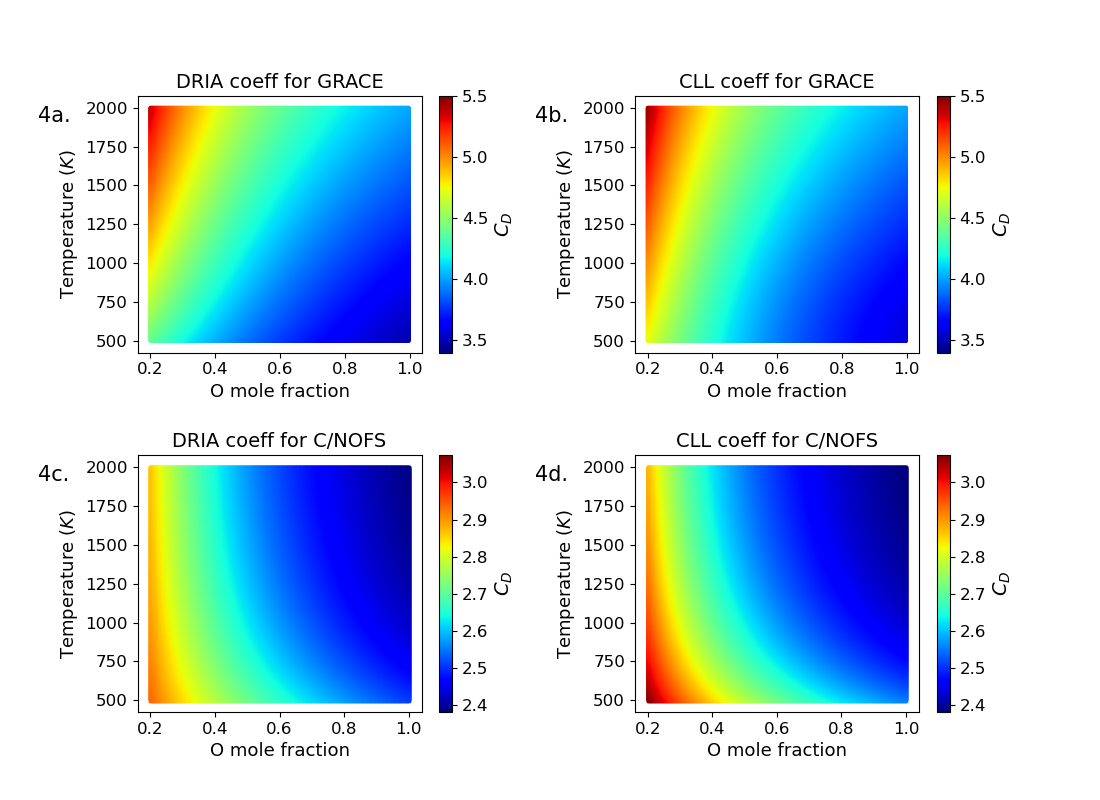

In [84]:
fig,ax = plt.subplots(2,2,figsize=[11,8],sharex=False,sharey=False)
plt.subplots_adjust(wspace=0.4,hspace=0.4)
# CD_DRIA_0 = np.mean([np.min(CD_DRIA[idx]),np.max(CD_DRIA[idx])])
# CD_CLL_0 = np.mean([np.min(CD_CLL[idx]),np.max(CD_CLL[idx])])

f0 = ax[0,0].scatter(CD_GRACE_0['X'],CD_GRACE_0['Y'],s=3,marker='o',c=CD_GRACE_0['DRIA'],cmap='jet',vmin=3.4,vmax=5.5)
ax[0,0].set_ylabel(r'Temperature ($K$)',fontsize=13)
ax[0,0].set_xlabel('O mole fraction',fontsize=13)
ax[0,0].set_title("DRIA coeff for GRACE",fontsize=14)
ax[0,0].tick_params(labelsize=12)
ax[0,0].set_yticks(np.arange(500,2001,250))
cbar = fig.colorbar(f0,ax=ax[0,0],label='$C_D$')
cbar.set_label(label='$C_{D}$', size=14, weight='bold')
cbar.ax.tick_params(labelsize=12)

f1 = ax[0,1].scatter(CD_GRACE_0['X'],CD_GRACE_0['Y'],s=3,marker='o',c=CD_GRACE_0['CLL'],cmap='jet',vmin=3.4,vmax=5.5)
ax[0,1].set_ylabel('Temperature ($K$)',fontsize=13)
ax[0,1].set_xlabel('O mole fraction',fontsize=13)
ax[0,1].set_title("CLL coeff for GRACE",fontsize=14)
ax[0,1].tick_params(labelsize=12)
ax[0,1].set_yticks(np.arange(500,2001,250))
cbar = fig.colorbar(f1,ax=ax[0,1])
cbar.set_label(label='$C_{D}$', size=14, weight='bold')
cbar.ax.tick_params(labelsize=12)


ax[0,0].text(-0.35, 0.9, "4a.", transform=ax[0,0].transAxes, fontsize=15, color='k',weight='regular')
ax[1,0].text(-0.35, 0.9, "4b.", transform=ax[0,1].transAxes, fontsize=15, color='k',weight='regular')

vmin = np.min([np.min(CD_CNOFS_0['DRIA']),np.min(CD_CNOFS_0['CLL'])])
vmax = np.max([np.max(CD_CNOFS_0['DRIA']),np.max(CD_CNOFS_0['CLL'])])

f0 = ax[1,0].scatter(CD_CNOFS_0['X'],CD_CNOFS_0['Y'],s=3,marker='s',c=CD_CNOFS_0['DRIA'],cmap='jet',vmin=vmin,vmax=vmax)
ax[1,0].set_ylabel(r'Temperature ($K$)',fontsize=13)
ax[1,0].set_xlabel('O mole fraction',fontsize=13)
ax[1,0].set_title("DRIA coeff for C/NOFS",fontsize=14)
ax[1,0].tick_params(labelsize=12)
cbar = fig.colorbar(f0,ax=ax[1,0],label='$C_D$')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label=r'$C_{D}$', size=14, weight='bold')

f1 = ax[1,1].scatter(CD_CNOFS_0['X'],CD_CNOFS_0['Y'],s=3,marker='s',c=CD_CNOFS_0['CLL'],cmap='jet',vmin=vmin,vmax=vmax)
ax[1,1].set_ylabel('Temperature ($K$)',fontsize=13)
ax[1,1].set_xlabel('O mole fraction',fontsize=13)
ax[1,1].tick_params(labelsize=12)
ax[1,1].set_title("CLL coeff for C/NOFS",fontsize=14)
cbar = fig.colorbar(f1,ax=ax[1,1])
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label=r'$C_{D}$', size=14, weight='bold')

ax[1,0].text(-0.35, 0.9, "4c.", transform=ax[1,0].transAxes, fontsize=15, color='k')
ax[1,1].text(-0.35, 0.9, "4d.", transform=ax[1,1].transAxes, fontsize=15, color='k')
# plt.tight_layout(pad=1.0)
plt.show()

# filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\plots\\"
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/plots/'
os.chdir(filepath);
filename = "CD_sens_0.jpg";
plt.savefig(filename,format='jpg',dpi=1200)

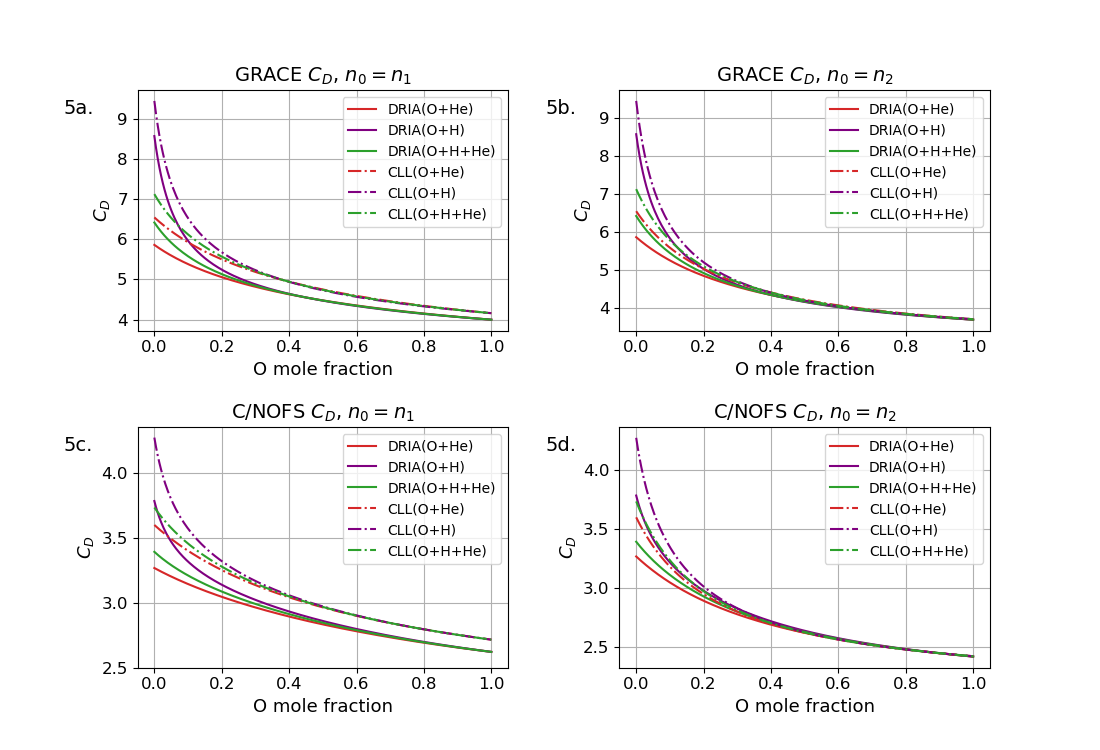

In [102]:
fig,ax = plt.subplots(2,2,figsize=[11,7.5],sharex=False)
plt.subplots_adjust(wspace=0.3,hspace=0.4)
ax[0,0].plot(CD_GRACE_1['X'],CD_GRACE_1['case1']['CD_DRIA_1'],'-',ms=3,label='DRIA(O+He)',c='tab:red')
ax[0,0].plot(CD_GRACE_1['X'],CD_GRACE_1['case1']['CD_DRIA_2'],'-',ms=3,label='DRIA(O+H)',c='purple')
ax[0,0].plot(CD_GRACE_1['X'],CD_GRACE_1['case1']['CD_DRIA_3'],'-',ms=3,label='DRIA(O+H+He)',c='tab:green')

ax[0,0].plot(CD_GRACE_1['X'],CD_GRACE_1['case1']['CD_CLL_1'],'-.',ms=1.5,label='CLL(O+He)',c='tab:red')
ax[0,0].plot(CD_GRACE_1['X'],CD_GRACE_1['case1']['CD_CLL_2'],'-.',ms=1.5,label='CLL(O+H)',c='purple')
ax[0,0].plot(CD_GRACE_1['X'],CD_GRACE_1['case1']['CD_CLL_3'],'-.',ms=1.5,label='CLL(O+H+He)',c='tab:green')

ax[0,0].set_xlabel('O mole fraction',fontsize=13)
ax[0,0].set_ylabel('$C_D$',fontsize=13)
lgnd = ax[0,0].legend(loc='best',markerscale=3)

ax[0,0].set_title(r'GRACE $C_{D}$, $n_{0} = n_{1}$',fontsize=14)

ax[0,1].plot(CD_GRACE_1['X'],CD_GRACE_1['case2']['CD_DRIA_1'],'-',ms=3,label='DRIA(O+He)',c='tab:red')
ax[0,1].plot(CD_GRACE_1['X'],CD_GRACE_1['case2']['CD_DRIA_2'],'-',ms=3,label='DRIA(O+H)',c='purple')
ax[0,1].plot(CD_GRACE_1['X'],CD_GRACE_1['case2']['CD_DRIA_3'],'-',ms=3,label='DRIA(O+H+He)',c='tab:green')

ax[0,1].plot(CD_GRACE_1['X'],CD_GRACE_1['case2']['CD_CLL_1'],'-.',ms=1.5,label='CLL(O+He)',c='tab:red')
ax[0,1].plot(CD_GRACE_1['X'],CD_GRACE_1['case2']['CD_CLL_2'],'-.',ms=1.5,label='CLL(O+H)',c='purple')
ax[0,1].plot(CD_GRACE_1['X'],CD_GRACE_1['case2']['CD_CLL_3'],'-.',ms=1.5,label='CLL(O+H+He)',c='tab:green')

ax[0,1].set_xlabel('O mole fraction',fontsize=13)
ax[0,1].set_ylabel('$C_D$',fontsize=13)
lgnd = ax[0,1].legend(loc='best',markerscale=3)

ax[0,1].set_title(r'GRACE $C_{D}$, $n_{0} = n_{2}$',fontsize=14)

ax[0,0].tick_params(labelsize=12)
ax[0,1].tick_params(labelsize=12)

ax[0,0].text(-0.2, 0.9, "5a.", transform=ax[0,0].transAxes, fontsize=14, color='k')
ax[0,1].text(-0.2, 0.9, "5b.", transform=ax[0,1].transAxes, fontsize=14, color='k')

ax[0,0].grid(which='both')
ax[0,1].grid(which='both')

ax[1,0].plot(CD_CNOFS_1['X'],CD_CNOFS_1['case1']['CD_DRIA_1'],'-',ms=3,label='DRIA(O+He)',c='tab:red')
ax[1,0].plot(CD_CNOFS_1['X'],CD_CNOFS_1['case1']['CD_DRIA_2'],'-',ms=3,label='DRIA(O+H)',c='purple')
ax[1,0].plot(CD_CNOFS_1['X'],CD_CNOFS_1['case1']['CD_DRIA_3'],'-',ms=3,label='DRIA(O+H+He)',c='tab:green')

ax[1,0].plot(CD_CNOFS_1['X'],CD_CNOFS_1['case1']['CD_CLL_1'],'-.',ms=1.5,label='CLL(O+He)',c='tab:red')
ax[1,0].plot(CD_CNOFS_1['X'],CD_CNOFS_1['case1']['CD_CLL_2'],'-.',ms=1.5,label='CLL(O+H)',c='purple')
ax[1,0].plot(CD_CNOFS_1['X'],CD_CNOFS_1['case1']['CD_CLL_3'],'-.',ms=1.5,label='CLL(O+H+He)',c='tab:green')

ax[1,0].set_xlabel('O mole fraction',fontsize=13)
ax[1,0].set_ylabel('$C_D$',fontsize=13)
ax[1,0].legend(loc='best',markerscale=3)
ax[1,0].set_title(r'C/NOFS $C_{D}$, $n_{0} = n_{1}$',fontsize=14)

ax[1,1].plot(CD_CNOFS_1['X'],CD_CNOFS_1['case2']['CD_DRIA_1'],'-',ms=3,label='DRIA(O+He)',c='tab:red')
ax[1,1].plot(CD_CNOFS_1['X'],CD_CNOFS_1['case2']['CD_DRIA_2'],'-',ms=3,label='DRIA(O+H)',c='purple')
ax[1,1].plot(CD_CNOFS_1['X'],CD_CNOFS_1['case2']['CD_DRIA_3'],'-',ms=3,label='DRIA(O+H+He)',c='tab:green')

ax[1,1].plot(CD_CNOFS_1['X'],CD_CNOFS_1['case2']['CD_CLL_1'],'-.',ms=1.5,label='CLL(O+He)',c='tab:red')
ax[1,1].plot(CD_CNOFS_1['X'],CD_CNOFS_1['case2']['CD_CLL_2'],'-.',ms=1.5,label='CLL(O+H)',c='purple')
ax[1,1].plot(CD_CNOFS_1['X'],CD_CNOFS_1['case2']['CD_CLL_3'],'-.',ms=1.5,label='CLL(O+H+He)',c='tab:green')

ax[1,1].set_xlabel('O mole fraction',fontsize=13)
ax[1,1].set_ylabel('$C_D$',fontsize=13)
ax[1,1].legend(loc='best',markerscale=3)
ax[1,1].set_title(r'C/NOFS $C_{D}$, $n_{0} = n_{2}$',fontsize=14)

ax[1,0].tick_params(labelsize=12)
ax[1,1].tick_params(labelsize=12)

ax[1,0].text(-0.2, 0.9, "5c.", transform=ax[1,0].transAxes, fontsize=14, color='k')
ax[1,1].text(-0.2, 0.9, "5d.", transform=ax[1,1].transAxes, fontsize=14, color='k')

ax[0,0].set_yticks(np.arange(4,9.1,1))
ax[0,1].set_yticks(np.arange(4,9.1,1))

ax[1,0].set_yticks(np.arange(2.5,4.5,0.5))
ax[1,1].set_yticks(np.arange(2.5,4.5,0.5))

ax[1,0].grid(which='both')
ax[1,1].grid(which='both')

# filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\plots\\"
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/plots/'
os.chdir(filepath);
filename = "CD_sens_1.jpg";
plt.savefig(filename,format='jpg',dpi=1200)

# plt.tight_layout(pad=3.0)

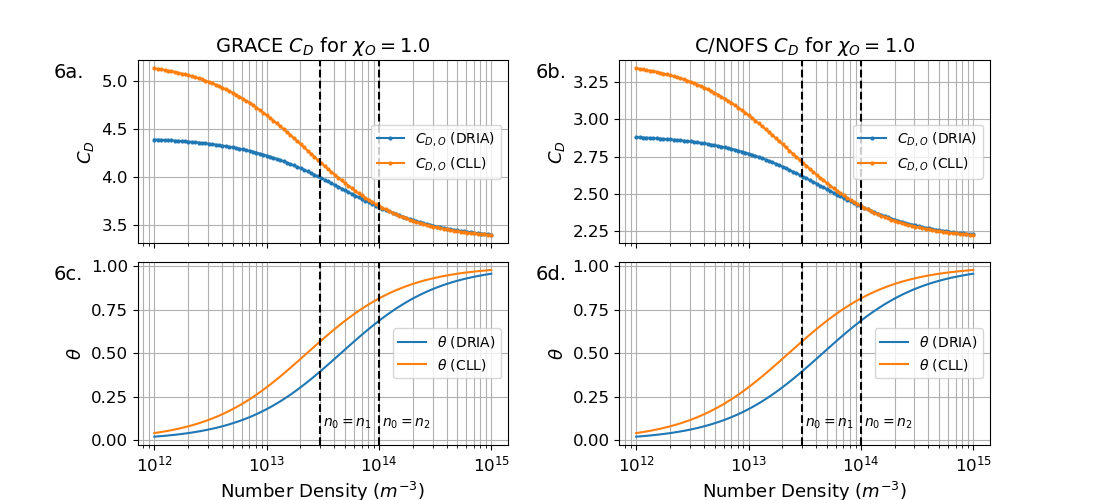

In [96]:
fig,ax = plt.subplots(2,2,figsize=[11,5],sharex=True)
plt.subplots_adjust(wspace=0.3,hspace=0.1)
ax[0,0].plot(CD_GRACE_2['n'],CD_GRACE_2['DRIA'],'-o',ms=2,label=r'$C_{D,O}$ (DRIA)')
ax[0,0].plot(CD_GRACE_2['n'],CD_GRACE_2['CLL'],'-o',ms=2,label=r'$C_{D,O}$ (CLL)')
ax[0,0].set_xscale('log')
ax[0,0].set_ylabel('$C_{D}$',fontsize=13)
ax[0,0].legend(loc='center right')
ax[0,0].set_title(r'GRACE $C_{D}$ for $\chi_{O} = 1.0$',fontsize=14)
ax[0,0].axvline(x=3.0e13,ls='--',c='k')
ax[0,0].axvline(x=1e14,ls='--',c='k')
ax[0,0].text(-0.225, 0.9, "6a.", transform=ax[0,0].transAxes, fontsize=14, color='k')
ax[0,0].grid(which='both')

Po = CD_GRACE_2['n']*k_B*temp0;
theta_DRIA = 1.44*10**6*Po/(1 + 1.44*10**6*Po)
theta_CLL = 2.89*10**6*Po/(1 + 2.89*10**6*Po)

ax[1,0].plot(CD_GRACE_2['n'],theta_DRIA,label=r'$\theta$ (DRIA)')
ax[1,0].plot(CD_GRACE_2['n'],theta_CLL,label=r'$\theta$ (CLL)')
ax[1,0].set_ylabel(r'$\theta$',fontsize=13)
ax[1,0].set_xlabel(r'Number Density ($m^{-3}$)',fontsize=13)
ax[1,0].axvline(x=3.0e13,ls='--',c='k')
ax[1,0].axvline(x=1e14,ls='--',c='k')
ax[1,0].set_yticks([0.0,0.25,0.50,0.75,1.0]);
ax[1,0].text(0.5, 0.1, r"$n_{0}=n_{1}$", transform=ax[1,0].transAxes, fontsize=10, color='k',weight='bold')
ax[1,0].text(0.66, 0.1, r"$n_{0}=n_{2}$", transform=ax[1,0].transAxes, fontsize=10, color='k',weight='bold')
ax[1,0].grid(which='both')
ax[1,0].text(-0.225, 0.9, "6c.", transform=ax[1,0].transAxes, fontsize=14, color='k')
ax[1,0].legend(loc='center right')


ax[0,1].plot(CD_CNOFS_2['n'],CD_CNOFS_2['DRIA'],'-o',ms=2,label=r'$C_{D,O}$ (DRIA)')
ax[0,1].plot(CD_CNOFS_2['n'],CD_CNOFS_2['CLL'],'-o',ms=2,label=r'$C_{D,O}$ (CLL)')
ax[0,1].set_xscale('log')
ax[0,1].set_ylabel('$C_{D}$',fontsize=13)
ax[0,1].legend(loc='center right')
ax[0,1].set_title(r'C/NOFS $C_{D}$ for $\chi_{O} = 1.0$',fontsize=14)
ax[0,1].axvline(x=3.0e13,ls='--',c='k')
ax[0,1].axvline(x=1e14,ls='--',c='k')
ax[0,1].text(-0.225, 0.9, "6b.", transform=ax[0,1].transAxes, fontsize=14, color='k')
ax[0,1].grid(which='both')

ax[1,1].plot(CD_GRACE_2['n'],theta_DRIA,label=r'$\theta$ (DRIA)')
ax[1,1].plot(CD_CNOFS_2['n'],theta_CLL,label=r'$\theta$ (CLL)')
ax[1,1].set_ylabel(r'$\theta$',fontsize=13)
ax[1,1].set_xlabel(r'Number Density ($m^{-3}$)',fontsize=13)
ax[1,1].axvline(x=3.0e13,ls='--',c='k')
ax[1,1].axvline(x=1e14,ls='--',c='k')
ax[1,1].set_yticks([0.0,0.25,0.50,0.75,1.0]);
ax[1,1].text(0.5, 0.1, r"$n_{0}=n_{1}$", transform=ax[1,1].transAxes, fontsize=10, color='k',weight='bold')
ax[1,1].text(0.66, 0.1, r"$n_{0}=n_{2}$", transform=ax[1,1].transAxes, fontsize=10, color='k',weight='bold')
ax[1,1].grid(which='both')
ax[1,1].text(-0.225, 0.9, "6d.", transform=ax[1,1].transAxes, fontsize=14, color='k')
ax[1,1].legend(loc='center right')

ax[0,0].tick_params(labelsize=12)
ax[0,1].tick_params(labelsize=12)
ax[1,0].tick_params(labelsize=12)
ax[1,1].tick_params(labelsize=12)

# filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\plots\\"
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/plots/'
os.chdir(filepath);
filename = "CD_sens_2.jpg";
plt.savefig(filename,format='jpg',dpi=1200)

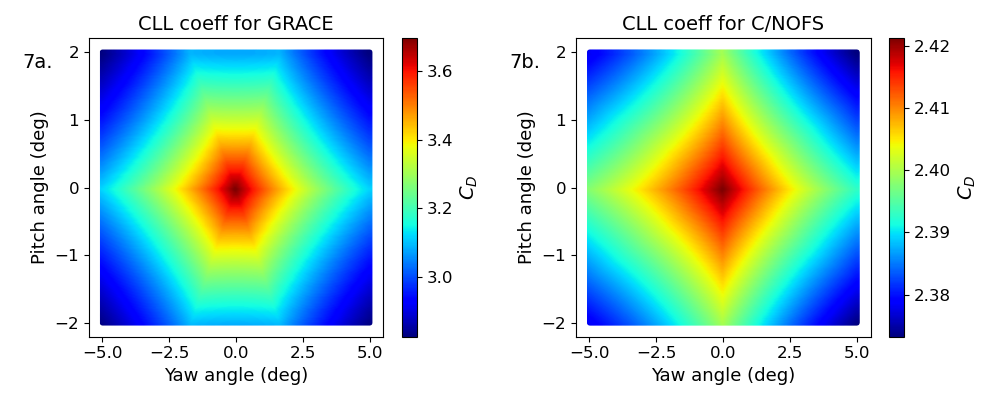

In [98]:
fig,ax = plt.subplots(1,2,figsize=[10,4],sharey=False)
plt.subplots_adjust(wspace=0.4)
f1 = ax[0].scatter(np.rad2deg(CD_GRACE_3['X']),np.rad2deg(CD_GRACE_3['Y']),s=5,c=CD_GRACE_3['CLL'],cmap='jet')
ax[0].set_xlabel('Yaw angle (deg)',fontsize=13)
ax[0].set_ylabel('Pitch angle (deg)',fontsize=13)

ax[0].tick_params(labelsize=12)
ax[0].text(-0.225, 0.9, "7a.", transform=ax[0].transAxes, fontsize=14, color='k')
ax[0].set_title("CLL coeff for GRACE",fontsize=14)

cbar=fig.colorbar(f1,ax=ax[0])
cbar.set_label(label=r'$C_{D}$', size=14, weight='bold')
cbar.ax.tick_params(labelsize=12)

f1 = ax[1].scatter(np.rad2deg(CD_CNOFS_3['X']),np.rad2deg(CD_CNOFS_3['Y']),s=5,c=CD_CNOFS_3['CLL'],cmap='jet')
ax[1].set_xlabel('Yaw angle (deg)',fontsize=13)
ax[1].set_ylabel('Pitch angle (deg)',fontsize=13)

ax[1].tick_params(labelsize=12)
ax[1].text(-0.225, 0.9, "7b.", transform=ax[1].transAxes, fontsize=14, color='k')
ax[1].set_title("CLL coeff for C/NOFS",fontsize=14)
cbar=fig.colorbar(f1,ax=ax[1])
cbar.set_label(label=r'$C_{D}$', size=14, weight='bold')
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
# filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\plots\\"
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/plots/'
os.chdir(filepath);
filename = "CD_sens_3.jpg";
plt.savefig(filename,format='jpg',dpi=1200)

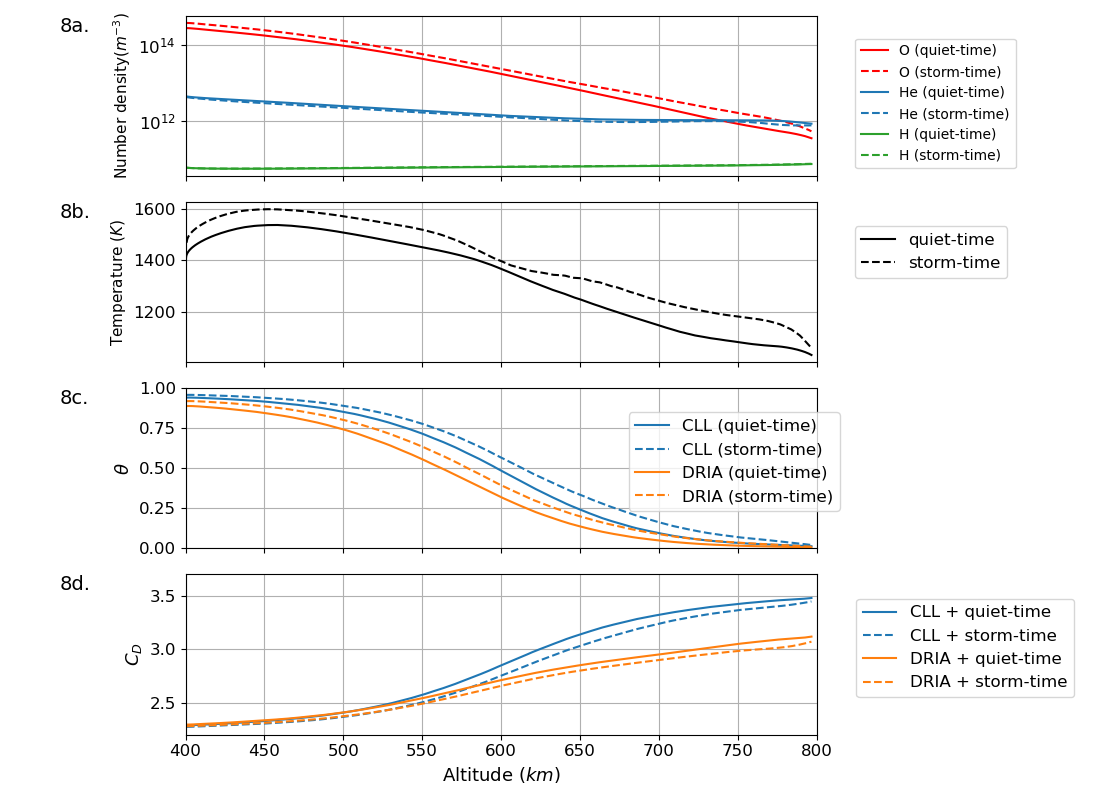

In [32]:
fig,ax = plt.subplots(4,1,figsize=[11,8],sharex=True)
plt.subplots_adjust(hspace=0.1)
ax[0].plot(df_qd['altitude'],O_dens_qd,label='O (quiet-time)',c='r',ls='-')
ax[0].plot(df_sd['altitude'],O_dens_sd,label='O (storm-time)',c='r',ls='--')
ax[0].plot(df_qd['altitude'],Data_GITM_qd['He'],label='He (quiet-time)',c='tab:blue',ls='-')
ax[0].plot(df_sd['altitude'],Data_GITM_sd['He'],label='He (storm-time)',c='tab:blue',ls='--')
ax[0].plot(df_qd['altitude'],Data_GITM_qd['H'],label='H (quiet-time)',c='tab:green',ls='-')
ax[0].plot(df_sd['altitude'],Data_GITM_sd['H'],label='H (storm-time)',c='tab:green',ls='--')
ax[0].set_ylabel(r'Number density($m^{-3}$)',fontsize=11)
ax[0].legend(fontsize=10,bbox_to_anchor = (1.05, 0.9))
# ax[0].set_ylim([0,1])
ax[0].set_xlim([400,800])
ax[0].set_yscale('log')
ax[0].grid()
ax[0].text(-0.2, 0.9, "8a.", transform=ax[0].transAxes, fontsize=14, color='k')
ax[0].tick_params(labelsize=12)


ax[1].plot(Data_GITM_qd['alt']/1000,Data_GITM_qd['Temperature'],label='quiet-time',c='k',ls='-')
ax[1].plot(Data_GITM_sd['alt']/1000,Data_GITM_sd['Temperature'],label='storm-time',c='k',ls='--')
ax[1].set_ylabel(r'Temperature ($K$)',fontsize=11)
ax[1].legend(fontsize=12,bbox_to_anchor = (1.315, 0.9))
ax[1].set_xlim([400,800])
ax[1].grid()
ax[1].text(-0.2, 0.9, "8b.", transform=ax[1].transAxes, fontsize=14, color='k')
ax[1].tick_params(labelsize=12)

ax[2].plot(df_qd['altitude'],theta_CLL_qd,'-',label='CLL (quiet-time)',c='tab:blue')
ax[2].plot(df_sd['altitude'],theta_CLL_sd,'--',label='CLL (storm-time)',c='tab:blue')
ax[2].plot(df_qd['altitude'],theta_DRIA_qd,'-',label='DRIA (quiet-time)',c='tab:orange')
ax[2].plot(df_sd['altitude'],theta_DRIA_sd,'--',label='DRIA (storm-time)',c='tab:orange')
ax[2].legend(fontsize=12,bbox_to_anchor = (1.05, 0.9))
ax[2].set_xlim([400,800])
ax[2].set_ylim([0,1])
ax[2].grid()
ax[2].set_ylabel(r'$\theta$',fontsize=13)
ax[2].text(-0.2, 0.9, "8c.", transform=ax[2].transAxes, fontsize=14, color='k')
ax[2].tick_params(labelsize=12)

ax[3].plot(df_qd['altitude'],CD_GITM_CLL_qd['C_D'],'-',label='CLL + quiet-time',c='tab:blue')
ax[3].plot(df_sd['altitude'],CD_GITM_CLL_sd['C_D'],'--',label='CLL + storm-time',c='tab:blue')
ax[3].plot(df_qd['altitude'],CD_GITM_DRIA_qd['C_D'],'-',label='DRIA + quiet-time',c='tab:orange')
ax[3].plot(df_sd['altitude'],CD_GITM_DRIA_sd['C_D'],'--',label='DRIA + storm-time',c='tab:orange')
ax[3].set_ylabel(r'$C_{D}$',fontsize=13)
ax[3].legend(fontsize=12,bbox_to_anchor = (1.05, 0.9))
ax[3].set_xlim([400,800])
ax[3].set_yticks([2.5,3,3.5])
ax[3].set_ylim([2.2,3.7])
ax[3].grid()
ax[3].set_xlabel(r'Altitude ($km$)',fontsize=13)
ax[3].text(-0.2, 0.9, "8d.", transform=ax[3].transAxes, fontsize=14, color='k')
ax[3].tick_params(labelsize=12)

plt.tight_layout()
# filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\plots\\"
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/plots/'
os.chdir(filepath);
filename = "CD_sens_4.jpg";
plt.savefig(filename,format='jpg',dpi=1200)
